In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.pyplot import imsave
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

In [17]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
image_pixels = 28
kernel = 5

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
sess = tf.InteractiveSession()

In [5]:
def weight_initialise(shape):
    value = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(value)

def bias_initialise(shape):
    value = tf.constant(0.1, shape=shape)
    return tf.Variable(value)


In [6]:
x = tf.placeholder(tf.float32, shape=[None, 784])
targets = tf.placeholder(tf.float32, shape=[None, 10])

In [7]:
#cnn
input_layer = tf.reshape(x, [-1, image_pixels, image_pixels, 1])

params_conv1 = weight_initialise([kernel, kernel, 1, 32])
bias_conv1 = bias_initialise([32])
output_conv1 = tf.nn.relu(tf.nn.conv2d(input_layer, params_conv1, strides=[1, 1, 1, 1], padding='SAME')+bias_conv1)
pool_conv1 = tf.nn.max_pool(output_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

params_conv2 = weight_initialise([kernel, kernel, 32, 64])
bias_conv2 = bias_initialise([64])
output_conv2 = tf.nn.relu(tf.nn.conv2d(pool_conv1, params_conv2, strides=[1, 1, 1, 1], padding='SAME')+bias_conv2)
pool_conv2 = tf.nn.max_pool(output_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

params_fc1 = weight_initialise([7*7*64, 1024])
bias_fc1 = bias_initialise([1024])

pool_conv2_flat = tf.reshape(pool_conv2, [-1, 7*7*64])

output_fc1 = tf.nn.relu(tf.matmul(pool_conv2_flat, params_fc1) + bias_fc1)

keep_prob = tf.placeholder(tf.float32)
dropout = tf.nn.dropout(output_fc1, keep_prob)

params_fc2 = weight_initialise([1024, 10])
bias_fc2 = bias_initialise([10])
y_conv = tf.matmul(dropout, params_fc2) + bias_fc2

In [8]:
y = tf.nn.softmax(y_conv)

In [9]:
# Loss and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=targets, logits=y_conv)
cross_entropy = tf.reduce_mean(cross_entropy)
train = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)

In [10]:
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(targets,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [11]:
sess.run(tf.global_variables_initializer())

In [12]:
# Train model
for i in range(1000):
    batch_x, batch_y = mnist.train.next_batch(100)
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, targets: batch_y, keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))

    train.run(feed_dict={x: batch_x, targets: batch_y, keep_prob: 0.5})

step 0, training accuracy 0.12
step 200, training accuracy 0.85
step 400, training accuracy 0.91
step 600, training accuracy 0.95
step 800, training accuracy 0.91


In [13]:
# Test model
print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images[0:500], 
                                                  targets: mnist.test.labels[0:500], keep_prob: 1.0}))

test accuracy 0.968


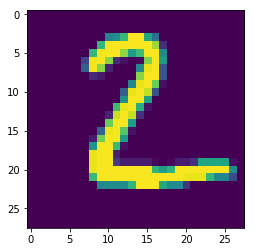

In [14]:
# original image
imageshow = mnist.test.images[1].reshape(28,28)
plt.imshow(imageshow)
plt.show()

step 0 adv accuracy nan


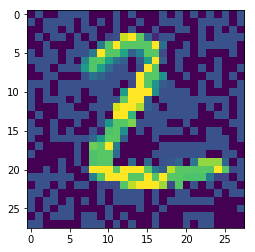

step 10 adv accuracy 0.1
step 20 adv accuracy 0.05
step 30 adv accuracy 0.0666667
step 40 adv accuracy 0.05
step 50 adv accuracy 0.04
step 60 adv accuracy 0.05
step 70 adv accuracy 0.0428571
step 80 adv accuracy 0.05
step 90 adv accuracy 0.0666667
step 100 adv accuracy 0.06
step 110 adv accuracy 0.0636364
step 120 adv accuracy 0.0583333


KeyboardInterrupt: 

In [18]:
#adversarial images
for i in range(1000):
    x_image = mnist.test.images[i]
    x_image= np.reshape(x_image, (1, 784))
    y_label=mnist.test.labels[i]
    
    original_image = x_image
    probs_per_step = []
    
    # Calculate loss, derivative and create adversarial image
    loss =  tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y_conv)
    grad = tf.gradients(loss, x)
    image_adv = x+tf.sign(grad)*0.25
    image_adv = tf.clip_by_value(image_adv, 0, 1) 
    
    dydx = sess.run(grad, {x: x_image, keep_prob: 1.0}) 
    x_adv = sess.run(image_adv, {x: x_image, keep_prob: 1.0})
    
    x_image = np.reshape(x_adv, (1, 784))
    img_adv_list = original_image
    img_adv_list = np.append(img_adv_list, dydx[0], axis=0)
    img_adv_list = np.append(img_adv_list, x_image, axis=0)
        
    prob = y.eval(feed_dict={x: img_adv_list, keep_prob: 1.0})
    for j in range(len(prob)):
        image= np.reshape(img_adv_list[j], (1, 784))
        if (j % 3 == 2): 
            mnist.test.images[i]=image
    
    # adversarial image
    if i==1:
        imageshow = mnist.test.images[1].reshape(28,28)
        plt.imshow(imageshow)
        plt.show()
        
    if i%10 == 0:
        print("step %d adv accuracy %g"%(i,accuracy.eval(feed_dict={x: mnist.test.images[0:i], 
                                                  targets: mnist.test.labels[0:i], keep_prob: 1.0})))